# TS5 — Estimación espectral y ancho de banda

**Materia:** Análisis y Procesamiento de Señales (APS) – UNSAM 

**Docentes:** Mariano Llamedo Soria, Francisco Hernan Ledesma y David Ezequiel Benoit

**Alumnas:** Naudeau Nahiara y Gil María Serena 

**Fecha de entrega:** 12/10/2025  

---

### Objetivo
Aplicar métodos no paramétricos (Periodograma ventaneado, Welch, Blackman–Tukey) para estimar la PSD de señales ECG, PPG y Audio, y calcular su ancho de banda efectivo.


---

## Introducción

En el análisis de señales no determinísticas, cuando queremos conocer cómo se distribuye la potencia en frecuencia calculamos la Densidad Espectral de Potencia (PSD, Power Spectral Density), que describe cuánta potencia contiene la señal en cada banda de frecuencias.
Si $x[n]$ es una realización discreta de una señal estacionaria, su PSD teórica está relacionada con la autocorrelación $r_{xx}=[m]$ mediante el teorema de Wiener–Khinchin:

$$S_{xx}(f) = \sum_{m=-\infty}^{\infty} r_{xx}[m]\, e^{-j 2 \pi f m}$$

Los métodos de estimación espectral se dividen en dos grandes grupos:

- Métodos no paramétricos: basados en la transformada de Fourier directa o en la autocorrelación (se utilizarán: Periodograma, Welch, Blackman–Tukey).

- Métodos paramétricos: basados en modelos (AR, MA, ARMA), que no serán utilizados en este trabajo.

### Periodograma

El periodograma es la forma más simple de estimar la PSD.
Consiste en tomar la Transformada Discreta de Fourier (DFT) de la señal y calcular el módulo cuadrado:
$$\hat{S}_{xx}(f) = \frac{1}{N f_s} \, \big| X(f) \big|^2$$
donde $X(f)=DFT{x[n]}$, $N$ es el número de muestras y $f_s$ la frecuencia de muestreo.

El periodograma es insesgado (su valor medio coincide con la PSD real), pero presenta una varianza muy alta, lo que hace que la estimación sea muy ruidosa.
Además, si la señal se corta bruscamente, aparecen fugas espectrales (leakage).
Por eso se suele aplicar una ventana temporal $w[n]$ antes de la DFT:
$$\hat{S}_{xx}(f) = \frac{1}{N f_s} \, \big| \text{DFT}\{x[n] \cdot w[n]\} \big|^2$$

### Welch

El método de Welch es una mejora del periodograma que busca reducir la varianza del estimador.

Los pasos principales son:

1. Dividir la señal en segmentos (posiblemente superpuestos).
2. Aplicar una ventana $w[n]$ a cada segmento.
3. Calcular el periodograma de cada segmento.
4. Promediar los periodogramas obtenidos.


El promedio disminuye la varianza de la estimación a costa de una leve pérdida de resolución espectral.
La elección del tamaño de segmento, porcentaje de solapamiento y tipo de ventana determinan el compromiso entre resolución y varianza.

Matemáticamente:
$$\hat{S}_{xx}(f) = \frac{1}{K} \sum_{i=1}^{K} \hat{S}_{xx,i}(f)$$
donde $K$ es el número de segmentos promediados.

### Blackman-Tukey

El método de Blackman–Tukey estima la PSD a partir de la autocorrelación muestral.
Primero se calcula la autocorrelación de la señal, luego se aplica una ventana en el dominio de los retardos (lags), y al final se toma su transformada de Fourier.

1. Calcula la autocorrelación estimada (biased):
$$\hat{r}_{xx}[m] = \frac{1}{N} \sum_{n=0}^{N-1-m} x[n]\,x[n+m]$$
2. Aplica una ventana $w[n]$ sobre los retardos:
$$r_w[m] = \hat{r}_{xx}[m] \cdot w[m]$$
3. Calcula la PSD:
$$\hat{S}_{xx}(f) = \frac{1}{f_s} \sum_{m=-M}^{M} r_w[m]\, e^{-j 2 \pi f m}$$
El truncamiento y la ventana sobre $r_{xx}[m]$ suavizan la PSD (baja varianza), pero reducen la resolución en frecuencia (aumentan el sesgo).
Este método es especialmente útil cuando se quiere analizar el compromiso entre resolución y suavizado.

### Estimación del ancho de banda

Una vez obtenida la PSD, se puede estimar el ancho de banda efectivo o bandwidth de una señal como el rango de frecuencias que contiene un cierto porcentaje de la potencia total

Si $S_{xx}(f)$ es la PSD y $df$ el paso en frecuencia, la potencia total es:
$$P_\text{total} = \sum S_{xx}(f) \, \Delta f$$
La potencia acumulada se obtiene con la suma parcial, y el ancho de banda se define como la frecuencia $f_B$ donde la potencia acumulada alcanza una fracción $\alpha$ de la total.
$$\displaystyle \frac{\sum_{f=0}^{f_B} S_{xx}(f)\,\Delta f}{P_\text{total}} = \alpha$$
Este valor representa el rango de frecuencias donde se concentra la mayor parte de la energía útil de la señal.

Al estimar el ancho de banda de una señal, el factor más importante suele ser la varianza del estimador espectral. Si la varianza es alta, el ancho de banda calculado puede variar mucho entre estimaciones. La resolución y el leakage también influyen: una buena resolución permite distinguir mejor los límites del ancho de banda, y un bajo leakage evita que la energía se disperse fuera de la banda real. Sin embargo, para obtener un valor confiable y estable, es clave reducir la varianza.

### Justificación de la selección de ventanas

Para todas las señales analizadas (ECG, PPG, Audio y ECG con ruido), elegimos ventanas Hann y Blackman porque ayudan a reducir el leakage y mejoran la estimación espectral. La ventana Hann ofrece buen equilibrio entre resolución y reducción de ruido, mientras que la Blackman reduce aún más el leakage. Usarlas en Welch y Periodograma permite obtener espectros más claros y confiables.


---

## Código

In [2]:
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io import wavfile

#--------------Para encontrar mi banda ancha--------------#
def estimar_BW(PSD, ff, cota):
    df = ff[1] - ff[0]
    energia_acumulada = np.cumsum(PSD * df)
    energia_total = energia_acumulada[-1]
    energia_corte = energia_total * cota
    idx_corte = np.where(energia_acumulada >= energia_corte)[0][0]
    frec_BW = ff[idx_corte]
    return frec_BW

eps = 1e-12

---
### Señal ECG

A continuación, se muestra la señal original de electrocardiograma y luego se estiman sus densidades espectrales de potencia (PSD) con los tres métodos estudiados:

- **Welch:** promedio de periodogramas superpuestos con ventana Blackman.  
- **Periodograma ventaneado:** estimación directa sobre toda la señal.  
- **Blackman–Tukey:** a partir de la autocorrelación truncada y ventaneada.

También se calcula la **potencia total** y el **ancho de banda efectivo** para los niveles del 95 %, 97 % y 99 % de energía.

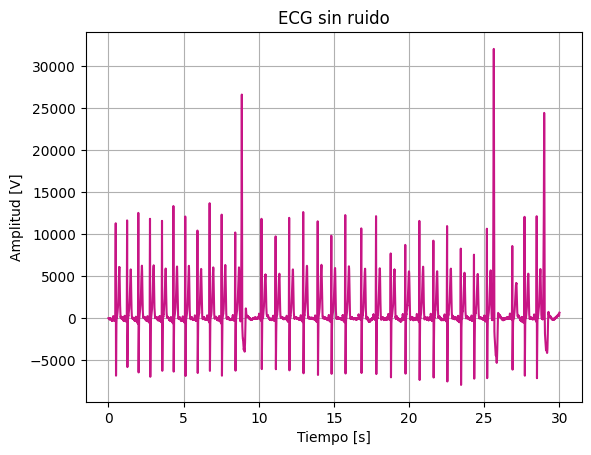

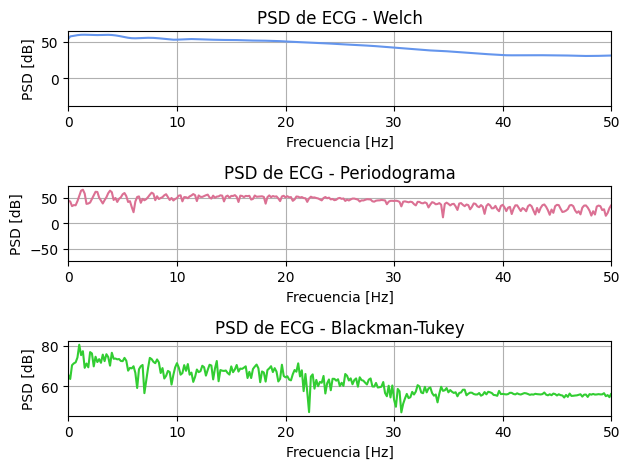

ECG
Potencia total (Welch): 7.3549e+06 V^2
BW con 95%: 22.50 Hz
BW con 97%: 25.17 Hz
BW con 99%: 30.50 Hz


In [9]:
fs_ecg = 1000
ecg = np.load('ecg_sin_ruido.npy')
N_ecg = len(ecg)

t = np.arange(N_ecg) / fs_ecg
plt.figure(1)
plt.plot(t, ecg, color='mediumvioletred')
plt.title('ECG sin ruido')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [V]')
plt.grid()
plt.show()

nperseg = N_ecg // 30
window = 'blackman'
nfft = 6 * nperseg

# Welch
freqW, ecgW = sig.welch(ecg, fs=fs_ecg, window=window, nperseg=nperseg, nfft=nfft)
# Periodograma con ventaneado
freqP, ecgP = sig.periodogram(ecg, fs=fs_ecg, window=window, nfft=nfft)
# Blackman-Tukey
corr = sig.correlate(ecg - np.mean(ecg), ecg - np.mean(ecg), mode='full')/ len(ecg) 
#lo de -np.mea es para centrar la señal antes de estimar la autocorrelación
corr = corr[corr.size // 2:]  #la mitad positiva
win_bt = sig.windows.bartlett(len(corr))
corr_win = corr * win_bt
PSD_bt = np.abs(np.fft.rfft(corr_win, n=nfft))
freqBT = np.fft.rfftfreq(nfft, d=1/fs_ecg)

# --- Gráficos en subplots ---
plt.figure(2)
plt.subplot(3, 1, 1)
plt.plot(freqW, 10*np.log10(ecgW + eps), color="cornflowerblue")
plt.title('PSD de ECG - Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 50])
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(freqP, 10*np.log10(ecgP + eps), color="palevioletred")
plt.title('PSD de ECG - Periodograma')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 50])
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(freqBT, 10*np.log10(PSD_bt + eps), color="limegreen")
plt.title('PSD de ECG - Blackman-Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 50])
plt.grid()

plt.tight_layout()
plt.show()

# Ancho de banda y potencia total (Welch)
df = freqW[1] - freqW[0]
potTotal = np.sum(ecgW) * df
f95 = estimar_BW(ecgW, freqW, 0.95)
f97 = estimar_BW(ecgW, freqW, 0.97)
f99 = estimar_BW(ecgW, freqW, 0.99)

print("=====================================")
print("ECG")
print(f"Potencia total (Welch): {potTotal:.4e} V^2")
print(f"BW con 95%: {f95:.2f} Hz")
print(f"BW con 97%: {f97:.2f} Hz")
print(f"BW con 99%: {f99:.2f} Hz")
print("=====================================")

---

**Análisis de resultados (ECG)**

La mayor parte de la energía se concentra entre 0 y 30 Hz, lo que confirma que se trata de una señal de *baja frecuencia y banda estrecha*, como es característico de un ECG.

Los tres métodos de estimación se comportan de forma coherente:
- **Welch** ofrece una curva suavizada y estable, con *baja varianza*.  
- **Periodograma** presenta picos más pronunciados debido a su *alta varianza*.  
- **Blackman–Tukey** logra un compromiso intermedio entre varianza y resolución.

Los anchos de banda efectivos calculados (95–99 %) se mantienen próximos, lo que valida la consistencia entre los métodos.


| Señal          | Potencia total (V²) | BW 95 % (Hz) | BW 97 % (Hz) | BW 99 % (Hz) |
|-----------------|---------------------|---------------|---------------|---------------|
| ECG          | 7.35×10⁶            | 22.5          | 23.2          | 30.5          |


---

### PPG

### Señal PPG (Pletismografía)

La señal **PPG** (Pletismografía) representa variaciones en el volumen sanguíneo periférico, y se caracteriza por ser una señal *biomédica de baja frecuencia y banda angosta*, típicamente entre *0.5 Hz y 5 Hz*, asociada al ritmo cardíaco.

En este análisis se utiliza un registro muestreado a *400 Hz*, sin ruido adicional.  
Se estimará la Densidad Espectral de Potencia (PSD) mediante los mismos métodos aplicados al ECG.

También se le calcularán los *anchos de banda efectivos* para 95 %, 97 % y 99 % de la energía total.

---

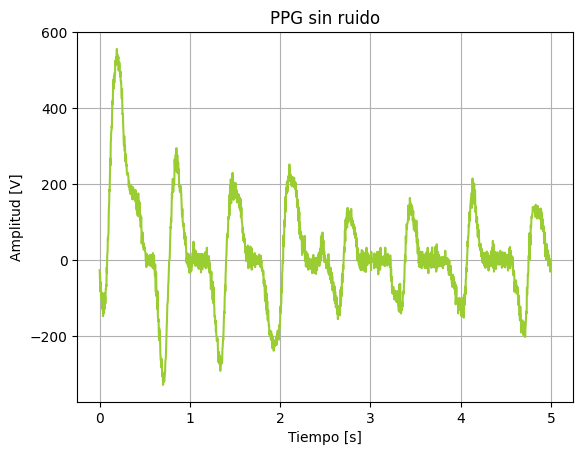

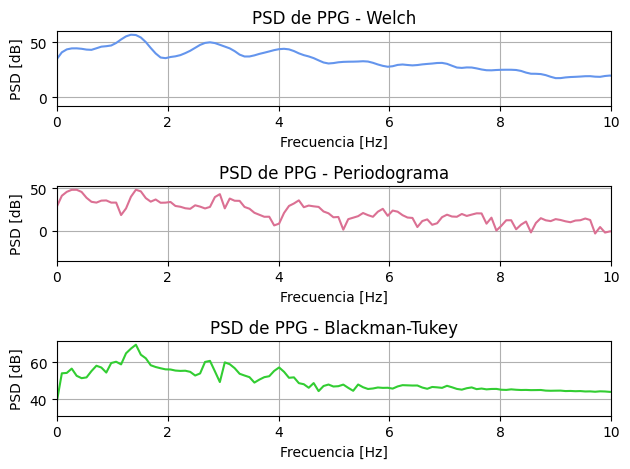

PPG
Potencia total (Welch): 2.7102e+05 V^2
BW con 95%: 4.01 Hz
BW con 97%: 4.19 Hz
BW con 99%: 5.43 Hz


In [10]:
fs_ppg = 400
ppg = np.load('ppg_sin_ruido.npy')
N_ppg = len(ppg)

t_ppg = np.arange(N_ppg) / fs_ppg
plt.figure(3)
plt.plot(t_ppg[:2000], ppg[:2000], color='yellowgreen')
plt.title('PPG sin ruido')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [V]')
plt.grid()
plt.show()

nperseg = N_ppg // 20
win = 'hann'
nfft = 2 * nperseg

freqW, ppgW = sig.welch(ppg, fs=fs_ppg, window=win, nperseg=nperseg, nfft=nfft)
freqP, ppgP = sig.periodogram(ppg, fs=fs_ppg, window=win, nfft=nfft)
corr = sig.correlate(ppg - np.mean(ppg), ppg - np.mean(ppg), mode='full')/ len(ecg)
corr = corr[corr.size // 2:]
win_bt = sig.windows.bartlett(len(corr))
corr_win = corr * win_bt
PSD_bt = np.abs(np.fft.rfft(corr_win, n=nfft))
freqBT = np.fft.rfftfreq(nfft, d=1/fs_ppg)

# --- Gráficos en subplots ---
plt.figure(4)
plt.subplot(3, 1, 1)
plt.plot(freqW, 10*np.log10(ppgW + eps), color="cornflowerblue")
plt.title('PSD de PPG - Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 10])
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(freqP, 10*np.log10(ppgP + eps), color="palevioletred")
plt.title('PSD de PPG - Periodograma')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 10])
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(freqBT, 10*np.log10(PSD_bt + eps), color="limegreen")
plt.title('PSD de PPG - Blackman-Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 10])
plt.grid()

plt.tight_layout()
plt.show()

df = freqW[1] - freqW[0]
potTotal = np.sum(ppgW) * df
f95 = estimar_BW(ppgW, freqW, 0.95)
f97 = estimar_BW(ppgW, freqW, 0.97)
f99 = estimar_BW(ppgW, freqW, 0.99)

print("=====================================")
print("PPG")
print(f"Potencia total (Welch): {potTotal:.4e} V^2")
print(f"BW con 95%: {f95:.2f} Hz")
print(f"BW con 97%: {f97:.2f} Hz")
print(f"BW con 99%: {f99:.2f} Hz")
print("=====================================")

---

**Análisis de resultados (PPG)**

Esta señal concentra la mayor parte de su energía entre *0 y 5 Hz*, lo que confirma su naturaleza de *baja frecuencia y banda angosta*.  
Los resultados muestran que:

- El **ancho de banda** se mantiene en torno a 4–5 Hz, con diferencias mínimas entre los tres criterios de potencia (95 %, 97 %, 99 %).  
- El método de **Welch** ofrece una curva suavizada y estable, con baja varianza.  
- El **Periodograma** presenta mayores fluctuaciones debido a su alta varianza.  
- **Blackman–Tukey** logra el mejor compromiso entre suavizado y resolución.

Esto valida que los tres métodos capturan la misma estructura espectral principal y que la señal PPG posee un contenido espectral dominado por componentes de muy baja frecuencia.


| Señal | Potencia total (V²) | BW 95 % (Hz) | BW 97 % (Hz) | BW 99 % (Hz) |
|--------|----------------------|---------------|---------------|---------------|
| PPG    | 2.72×10⁵            | 4.01          | 4.19          | 5.43          |

---

### Señal de Audio ("La Cucaracha")

La tercera señal corresponde a un *registro de audio*, *"La Cucaracha"*.  
A diferencia de las señales fisiológicas (ECG y PPG), esta señal contiene *armónicos, formantes y transitorios* distribuidos en un espectro mucho más amplio, por lo que se considera de *banda ancha*.

En este caso, se utiliza el mismo procedimiento que en los casos anteriores para estimar la *PSD* itilizando los tres mismos metodos.
Tambien se calcularán los *anchos de banda efectivos*.


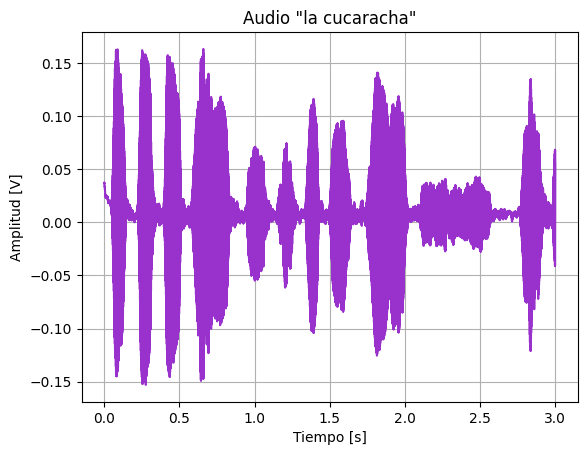

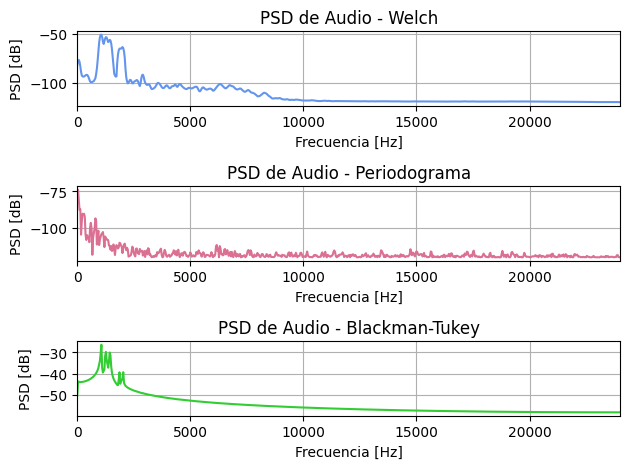

AUDIO
Potencia total (Welch): 1.8211e-03 V^2
BW con 95%: 1533.33 Hz
BW con 97%: 1900.00 Hz
BW con 99%: 2000.00 Hz


In [11]:
fs_audio, audio = wavfile.read('la cucaracha.wav')
if audio.ndim > 1:
    audio = audio[:,0]
N_aud = len(audio)

t_audio = np.arange(N_aud) / fs_audio
plt.figure(5)
plt.plot(t_audio, audio, color='darkorchid')
plt.title('Audio "la cucaracha"')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [V]')
plt.grid()
plt.show()

nperseg = N_aud // 200
win = 'hann'
nfft = 2 * nperseg

freqW, audW = sig.welch(audio, fs=fs_audio, window=win, nperseg=nperseg, nfft=nfft)
freqP, audP = sig.periodogram(audio, fs=fs_audio, window=win, nfft=nfft)
corr = sig.correlate(audio - np.mean(audio), audio - np.mean(audio), mode='full')/ len(audio)
corr = corr[corr.size // 2:]
win_bt = sig.windows.bartlett(len(corr))
corr_win = corr * win_bt
PSD_bt = np.abs(np.fft.rfft(corr_win, n=nfft))
freqBT = np.fft.rfftfreq(nfft, d=1/fs_audio)

# --- Gráficos en subplots ---
plt.figure(6)
plt.subplot(3, 1, 1)
plt.plot(freqW, 10*np.log10(audW + eps), color="cornflowerblue")
plt.title('PSD de Audio - Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, fs_audio/2])
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(freqP, 10*np.log10(audP + eps), color="palevioletred")
plt.title('PSD de Audio - Periodograma')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, fs_audio/2])
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(freqBT, 10*np.log10(PSD_bt + eps), color="limegreen")
plt.title('PSD de Audio - Blackman-Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, fs_audio/2])
plt.grid()

plt.tight_layout()
plt.show()

df = freqW[1] - freqW[0]
potTotal = np.sum(audW) * df
f95 = estimar_BW(audW, freqW, 0.95)
f97 = estimar_BW(audW, freqW, 0.97)
f99 = estimar_BW(audW, freqW, 0.99)

print("=====================================")
print("AUDIO")
print(f"Potencia total (Welch): {potTotal:.4e} V^2")
print(f"BW con 95%: {f95:.2f} Hz")
print(f"BW con 97%: {f97:.2f} Hz")
print(f"BW con 99%: {f99:.2f} Hz")
print("=====================================")

---

**Análisis de resultados (Audio)**

En este caso, la señal de audio muestra un *ancho de banda amplio*, con la mayor parte de la energía concentrada por debajo de *2 kHz (99 % de la potencia)*.  
A diferencia de las señales fisiológicas, el audio posee un *contenido espectral más amplio* y una *mayor variabilidad en frecuencia*, debido a los fonemas y armónicos de la voz.

Respecto a los métodos:
- El **Blackman–Tukey** se presenta ahora como el método de *menor varianza*, debido al fuerte suavizado que impone la ventana sobre la autocorrelación.  
- El **Welch**, si bien ya no es el más estable, ofrece un buen compromiso entre resolución y varianza.  
- El **Periodograma** mantiene su alta varianza y mayor fluctuación espectral.


| Señal | Potencia total (V²) | BW 95 % (Hz) | BW 97 % (Hz) | BW 99 % (Hz) |
|--------|----------------------|---------------|---------------|---------------|
| Audio  | 1.82×10⁻³            | 1533          | 1980          | 2000          |

---


## Bonus – ECG con ruido

Como análisis adicional, se estudia la *robustez de los métodos espectrales frente al ruido*.  
Para ello se toma un registro de **ECG contaminado con ruido**, y se repite el cálculo de la *PSD* mediante los tres métodos.

El objetivo es observar cómo se modifican la **forma espectral**, la **varianza** y el **ancho de banda efectivo** respecto al ECG sin ruido, y determinar cuál método ofrece mejor **estabilidad** frente a perturbaciones.



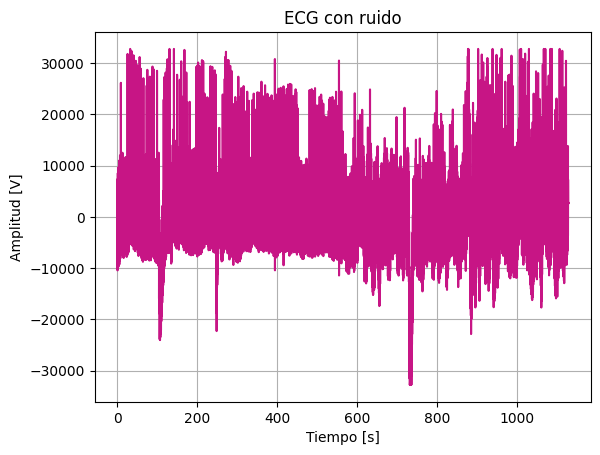

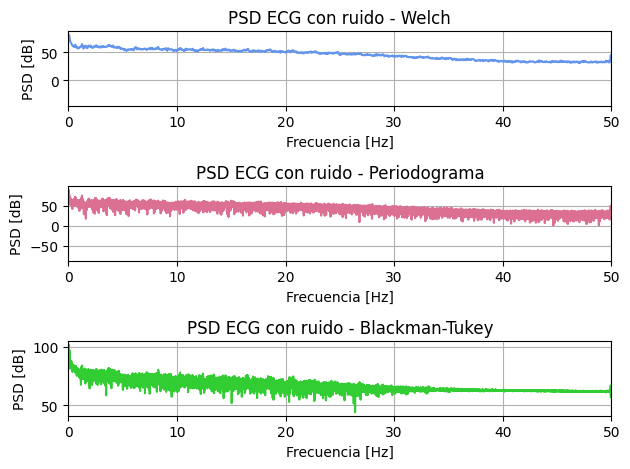

ECG CON RUIDO
Potencia total (Welch): 2.2174e+07 V^2
BW con 95%: 17.93 Hz
BW con 97%: 20.78 Hz
BW con 99%: 26.90 Hz


In [12]:
##################
## ECG con ruido
##################

# para listar las variables que hay en el archivo
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_ruido = mat_struct['ecg_lead'].flatten()  # señal con ruido (1D)
N_ecg_ruido = len(ecg_ruido)

hb_1 = mat_struct['heartbeat_pattern1']
hb_2 = mat_struct['heartbeat_pattern2']

t_ecg_ruido = np.arange(N_ecg_ruido) / fs_ecg
plt.figure(7)
plt.plot(t_ecg_ruido, ecg_ruido, color='mediumvioletred')
plt.title('ECG con ruido')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [V]')
plt.grid()
plt.show()

# Parámetros (idénticos a los del ECG sin ruido)
nperseg = N_ecg_ruido // 30
window = 'blackman'
nfft = 6 * nperseg

# Welch
freqW_r, ecgW_r = sig.welch(ecg_ruido, fs=fs_ecg, window=window, nperseg=nperseg, nfft=nfft)

# Periodograma
freqP_r, ecgP_r = sig.periodogram(ecg_ruido, fs=fs_ecg, window=window, nfft=nfft)

# Blackman–Tukey
corr_r = sig.correlate(ecg_ruido - np.mean(ecg_ruido), ecg_ruido - np.mean(ecg_ruido), mode='full') / N_ecg_ruido
corr_r = corr_r[corr_r.size // 2:]
win_bt = sig.windows.bartlett(len(corr_r))
corr_win_r = corr_r * win_bt
PSD_bt_r = np.abs(np.fft.rfft(corr_win_r, n=nfft))
freqBT_r = np.fft.rfftfreq(nfft, d=1/fs_ecg)

# --- Gráficos en subplots ---
plt.figure(8)
plt.subplot(3, 1, 1)
plt.plot(freqW_r, 10*np.log10(ecgW_r + eps), color="cornflowerblue")
plt.title('PSD ECG con ruido - Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 50])
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(freqP_r, 10*np.log10(ecgP_r + eps), color="palevioletred")
plt.title('PSD ECG con ruido - Periodograma')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 50])
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(freqBT_r, 10*np.log10(PSD_bt_r + eps), color="limegreen")
plt.title('PSD ECG con ruido - Blackman-Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 50])
plt.grid()

plt.tight_layout()
plt.show()

# ---- Potencia total y ancho de banda ----
df_r = freqW_r[1] - freqW_r[0]
potTotal_r = np.sum(ecgW_r) * df_r
f95_r = estimar_BW(ecgW_r, freqW_r, 0.95)
f97_r = estimar_BW(ecgW_r, freqW_r, 0.97)
f99_r = estimar_BW(ecgW_r, freqW_r, 0.99)

print("=====================================")
print("ECG CON RUIDO")
print(f"Potencia total (Welch): {potTotal_r:.4e} V^2")
print(f"BW con 95%: {f95_r:.2f} Hz")
print(f"BW con 97%: {f97_r:.2f} Hz")
print(f"BW con 99%: {f99_r:.2f} Hz")
print("=====================================")

---
Al analizar la señal de ECG contaminada con ruido mediante los tres métodos se pudo ver que en los gráficos obtenido el periodograma presenta una gran variabilidad punto a punto, dando a entender que posee una varianza alta, aunque ofrece una buena resolución espectral al distinguir componentes finas. El método de Welch, al promediar varios periodogramas de segmentos superpuestos, redujo significativamente la varianza a costa de una menor resolución espectral, generando una estimación más suave y estable. Finalmente, el método de Blackman–Tukey utiliza la autocorrelación truncada y suavizada por una ventana, logrando un compromiso intermedio entre varianza y resolución. En conjunto, el análisis muestra cómo la elección del método implica un compromiso entre la estabilidad la precisión en frecuencia, siendo Welch el mejor frente al ruido en este caso.


| Métrica                | ECG con ruido |
|-----------------------:|:-------------:|
| Potencia total (V²)    | 2.2174e+07    |
| BW 95 % (Hz)           |     17.93     |
| BW 97 % (Hz)           |     20.78     |
| BW 99 % (Hz)           |     26.98     |

---


## Conclusiones finales

El análisis espectral permitió comparar distintos métodos no paramétricos de estimación de PSD sobre señales de naturaleza muy diferente: **ECG**, **PPG** y **Audio**.

- Las señales *ECG* y *PPG* demostraron ser de *baja frecuencia y banda angosta*, concentrando su energía por debajo de los 30 Hz y 5 Hz respectivamente.  
- La señal de *Audio* presentó un comportamiento opuesto, con un espectro de *banda ancha* que se extiende hasta varios kHz, propio de señales no estacionarias.  
- El *método de Welch* resultó el más *estable y robusto* frente a ruido y variabilidad, al reducir la varianza mediante el promediado de segmentos.  
- El *Blackman–Tukey* ofreció un *suavizado importante*, útil para representar tendencias globales pero con menor resolución espectral.  
- El *Periodograma ventaneado* mostró la *mayor resolución* pero también la *mayor varianza*, siendo más sensible a ruido y fluctuaciones.  

En el análisis de **ECG con ruido**, se verificó que Welch mantiene una estimación estable, mientras que el periodograma se ve fuertemente afectado por la varianza y Blackman–Tukey conserva un equilibrio intermedio.

En conjunto, los resultados confirman que *la elección del método depende del tipo de señal*:
- Para señales fisiológicas o estacionarias conviene usar *Welch*.  
- Para señales complejas o ruidosas, *Blackman–Tukey* ofrece mayor suavizado.  
- Para análisis de detalle fino o componentes discretas el *Periodograma* permite máxima resolución.

El trabajo evidencia la importancia de comprender el *compromiso entre varianza y resolución*, y cómo la correcta selección del método de estimación espectral mejora la interpretación física de las señales.

Por último, cabe destacar que el estimador de ancho de banda está directamente influido por la varianza de la estimación espectral. Métodos como el periodograma, al presentar alta varianza, pueden generar fluctuaciones en el valor estimado del ancho de banda. En cambio, técnicas como Welch y Blackman–Tukey, al reducir la varianza mediante promediado o suavizado, permiten obtener estimaciones de ancho de banda más estables y confiables. Por lo tanto, la elección del método espectral afecta de manera significativa la precisión y robustez del estimador de ancho de banda.